In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import imdb
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as k
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
max_sequence_length = 100
num_distinct_words = 10000

#Download Dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_distinct_words)

In [3]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [4]:
x_test1 = x_test[0:5000]
y_test1 = y_test[0:5000]

In [5]:
print(x_train.shape)
print(y_train.shape)

print(x_test1.shape)
print(y_test1.shape)

(25000,)
(25000,)
(5000,)
(5000,)


In [8]:
# Pad all sequences
# Pad x_train and x_test1

from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_x_train = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0)
padded_x_test1 = pad_sequences(x_test1, maxlen=max_sequence_length, value = 0.0)

In [9]:
print(padded_x_train.shape)
print(padded_x_test1.shape)

(25000, 100)
(5000, 100)


In [65]:
# Sparse CNN Autoencoder
inputs = Input(shape =(max_sequence_length), name = 'encoder_input')

def encoder(inp):
  em = Embedding(10000,50)(inp)
  conv1 = Conv1D(filters= 32, kernel_size =4, activation ='relu',padding='same', name ='encoder_conv1')(em)
  pool1 = MaxPool1D(pool_size =4,strides =1,name ='encoder_pool1')(conv1)
  # The last layer in encoding
  drop = tf.keras.layers.Dropout(0.3)(pool1)
  encoding = Dense(units = 32,activation ='linear', activity_regularizer =tf.keras.regularizers.L1(l1=0.01) ,name ='encoder_dense1')(drop)

  return encoding

In [66]:
def decoder(encoding):
  convT1 = Conv1DTranspose(32,kernel_size = 4,activation ='relu')(encoding)
  d = BatchNormalization()(convT1)
  flat = Flatten()(d)
  decoding = Dense(1, activation ='sigmoid')(flat)
  return decoding

In [67]:
autoencoder = Model(inputs =inputs,outputs = decoder(encoder( inputs )))
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 100)]             0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 100, 50)           500000    
_________________________________________________________________
encoder_conv1 (Conv1D)       (None, 100, 32)           6432      
_________________________________________________________________
encoder_pool1 (MaxPooling1D) (None, 97, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 97, 32)            0         
_________________________________________________________________
encoder_dense1 (Dense)       (None, 97, 32)            1056      
_________________________________________________________________
conv1d_transpose_15 (Conv1DT (None, 100, 32)           412

In [68]:
optimizer = tf.keras.optimizers.Adam(0.00002)
autoencoder.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy'])
history = autoencoder.fit(x=padded_x_train,y= y_train,epochs=50,batch_size =32,
                          validation_data =(padded_x_test1 ,y_test1),verbose=1).history

Epoch 1/50
782/782 [==============================] - 26s 32ms/step - loss: 1.5064 - accuracy: 0.5048 - val_loss: 1.1057 - val_accuracy: 0.5012
Epoch 2/50
782/782 [==============================] - 24s 31ms/step - loss: 1.1363 - accuracy: 0.5281 - val_loss: 0.9616 - val_accuracy: 0.5156
Epoch 3/50
782/782 [==============================] - 25s 32ms/step - loss: 0.9401 - accuracy: 0.5571 - val_loss: 0.8374 - val_accuracy: 0.5362
Epoch 4/50
782/782 [==============================] - 25s 32ms/step - loss: 0.8023 - accuracy: 0.5815 - val_loss: 0.7505 - val_accuracy: 0.5756
Epoch 5/50
782/782 [==============================] - 25s 32ms/step - loss: 0.7289 - accuracy: 0.6175 - val_loss: 0.7084 - val_accuracy: 0.6224
Epoch 6/50
782/782 [==============================] - 25s 32ms/step - loss: 0.6725 - accuracy: 0.6843 - val_loss: 0.6286 - val_accuracy: 0.6984
Epoch 7/50
782/782 [==============================] - 25s 32ms/step - loss: 0.5552 - accuracy: 0.7592 - val_loss: 0.5302 - val_accuracy:

In [39]:
y=autoencoder.predict(padded_x_test1)
y.shape

(5000, 100)

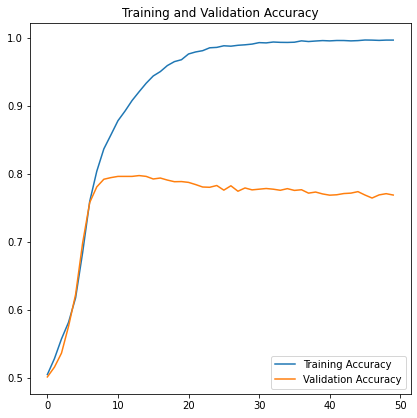

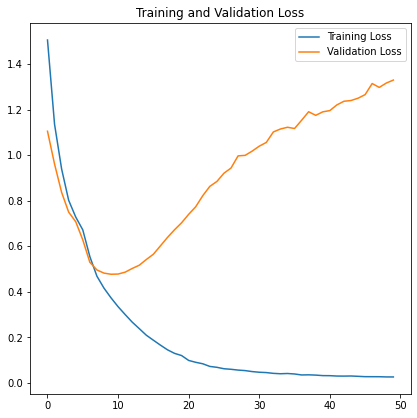

In [69]:
acc = history['accuracy']
val_acc = history['val_accuracy']
#auc = history['auc']
#val_auc = history['val_auc']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(15,15))
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()